In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats
import seaborn as sns
from glob import glob

plt.style.use('seaborn-whitegrid')

In [9]:
def get_ds_language(ds):
    if ds in ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020']:
        return 'german'
    return 'english'

analysis_dict = {}

def plot_score(score=None, dataset=None, train_test=None, xlim=None, ylim=None):
    filter_str = '*'.join(filter(None,[score or '*', dataset, train_test])) + '*'
    for file in glob(f'lively/{filter_str}.csv'):
        f_parts = file.split('_')
        train_test = f_parts[-1]
        ds = f_parts[-2]
        score = '_'.join(f_parts[:-2])
        df_score = pd.read_csv(file)
        bins = np.arange(xlim[0], xlim[1], (xlim[1]-xlim[0])/10) if xlim else 10
        df_score.plot(kind='hist', title=f'{ds} ({train_test})', xlim=xlim, ylim=ylim, bins=bins)
        
def describe_score(score=None, dataset=None, train_test=None):
    filter_str = '*'.join(filter(None,[score or '*', dataset, train_test])) + '*'
    for file in glob(f'lively/{filter_str}.csv'):
        f_parts = file.split('_')
        train_test = f_parts[-1]
        ds = f_parts[-2]
        score = '_'.join(f_parts[:-2])
        stats = pd.read_csv(file).describe()
        print(file, stats.loc['mean'].values[0], '+-', stats.loc['std'].values[0])
        
def get_score(score=None, dataset=None, train_test=None):
    filter_str = '*'.join(filter(None,[score or '*', dataset, train_test])) + '*'
    stat_entries = []
    for file in glob(f'lively/{filter_str}.csv'):
        f_parts = file.split('_')
        train_test = f_parts[-1]
        ds = f_parts[-2]
        score = '_'.join(f_parts[:-2]).split('\\')[-1]
        stats = pd.read_csv(file).describe()
        stat_entries.append({
            'dataset': ds,
            'score': score,
            'mean': stats.loc['mean'].values[0],
            'std': stats.loc['std'].values[0]
        })
    return pd.DataFrame(stat_entries)

source_dir = '../../zimp_orchestrator/orch/resources'
def sample_top_n_texts(score, dataset, train_test, n=10, ascending=False):
    file = f'lively/{score}_{dataset}_{train_test}.csv'
    df_scores = pd.read_csv(file)
    source_file = os.path.join(source_dir, dataset, train_test + '.csv')
    df_texts = pd.read_csv(source_file)
    top_idx = df_scores.sort_values(df_scores.columns[0], ascending=ascending).index[:n]
    return list(zip(df_scores.loc[top_idx].values, df_texts.text.loc[top_idx].values))
    

In [17]:
df_scores = get_score(train_test='test')
df_scores.head()

,dataset,score,mean,std
0,10K-GNAD,lively_default_score,4657.308743,467.525007
1,DBP-14,lively_default_score,2880.823282,749.706056
2,GERMEVAL-2018,lively_default_score,3948.324696,1289.290476
3,GERMEVAL-2020,lively_default_score,5269.733670,1172.036510
4,TREC-6,lively_default_score,3636.725356,1038.838706


In [53]:
def get_latex_score_name(score):
    if score == 'lively_default_score':
        return 'L_3'
    if score == 'lively_train_score':
        return 'L_3^T'
    if score == 'oov_default_size':
        return 'L_2'
    if score == 'oov_train_size':
        return 'L_2^T'
    if score == 'vocab_size':
        return 'L_1'
    return '??'

def get_latex_metric(metric_str, max_abs_score, std):
    is_max = np.abs(metric_str) == max_abs_score
    
    if metric_str > 999:
        metric_str = f'({np.round(metric_str/1000, 1)} \\pm {round(std/1000)})*10^3'
    else:
        metric_str = str(np.round(metric_str,1)) + ' \\pm ' + str(round(std))
    if is_max:
        return '\mathbf{' + str(metric_str) + '}'
    return metric_str

In [54]:
print("""
\\begin{table}[]
    \small
    \centering
    \\begin{tabular}{l|ccc|ccc}
        Score & \\texttt{DBP-14} & \\texttt{Trec-6} & \\texttt{Yelp-5} & \\texttt{10kGNAD} & \\texttt{GermEval2018} & \\texttt{GermEval2020} \\\\ \hline
""")

analyzed_datasets = ['DBP-14', 'TREC-6', 'YELP-5' , '10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020']

for score in reversed(df_scores.score.unique()):
    top_score = df_scores[df_scores.score == score]['mean'].max()
    if 'lively' in score:
        # for credit value based score small values indicate higher complexity
        top_score = df_scores[df_scores.score == score]['mean'].min()
    s = ' ' * 8
    s += '$' + get_latex_score_name(score) + '$ & '
    metrics_list = []
    for ds in analyzed_datasets:
        score_row = df_scores[(df_scores.dataset==ds) & (df_scores.score==score)].iloc[0]
        metrics_list.append(get_latex_metric(score_row['mean'], top_score, score_row['std']))
    s += ' & '.join([f'${m}$' for m in metrics_list])
    s +=  ' \\\\'
    print(s)

print("""
    \end{tabular}
    \caption[Lively Scores]{Lively scores for the test sets of analyzed datasets. $L_1$ is vocabulary size, $L_2$ out-of-vocabulary count, $L_3$ the credit value based score.
    Scores marked with $L_i^T$ are based on the relative training set instead of a reference vocabulary.}
    \label{tab:lively}
\end{table}
""")


\begin{table}[]
    \small
    \centering
    \begin{tabular}{l|ccc|ccc}
        Score & \texttt{DBP-14} & \texttt{Trec-6} & \texttt{Yelp-5} & \texttt{10kGNAD} & \texttt{GermEval2018} & \texttt{GermEval2020} \\ \hline

        $L_1$ & $39.5 \pm 16$ & $7.3 \pm 2$ & $91.3 \pm 62$ & $\mathbf{226.4 \pm 139}$ & $19.3 \pm 15$ & $19.4 \pm 10$ \\
        $L_2^T$ & $7.4 \pm 5$ & $0.6 \pm 1$ & $5.5 \pm 8$ & $\mathbf{64.0 \pm 55}$ & $4.2 \pm 7$ & $1.8 \pm 1$ \\
        $L_2$ & $21.2 \pm 10$ & $2.3 \pm 1$ & $39.9 \pm 38$ & $\mathbf{135.9 \pm 102}$ & $9.5 \pm 13$ & $6.2 \pm 4$ \\
        $L_3^T$ & $(6.9 \pm 1)*10^3$ & $(6.8 \pm 1)*10^3$ & $(8.9 \pm 1)*10^3$ & $(6.7 \pm 1)*10^3$ & $\mathbf{(6.6 \pm 1)*10^3}$ & $(7.9 \pm 1)*10^3$ \\
        $L_3$ & $\mathbf{(2.9 \pm 1)*10^3}$ & $(3.6 \pm 1)*10^3$ & $(4.2 \pm 1)*10^3$ & $(4.7 \pm 0)*10^3$ & $(3.9 \pm 1)*10^3$ & $(5.3 \pm 1)*10^3$ \\

    \end{tabular}
    \caption[Lively Scores]{Lively scores for the test sets of analyzed datasets. $L_1$ is vocabular

In [ ]:
plot_score(score='lively_default_score', train_test='train', xlim=(1000,8000))

In [4]:
describe_score(score='lively_default_score')

lively\lively_default_score_10K-GNAD_test.csv 4657.308743331424 +- 467.52500650464737
lively\lively_default_score_10K-GNAD_train.csv 4651.072925557061 +- 481.40894310774127
lively\lively_default_score_DBP-14_test.csv 2880.8232818646643 +- 749.7060555930624
lively\lively_default_score_DBP-14_train.csv 2881.1521005313057 +- 749.4112764067098
lively\lively_default_score_GERMEVAL-2018_test.csv 3948.3246957255406 +- 1289.29047649114
lively\lively_default_score_GERMEVAL-2018_train.csv 4038.1193967301388 +- 1214.9569081826085
lively\lively_default_score_GERMEVAL-2020_test.csv 5269.733669570502 +- 1172.0365104590712
lively\lively_default_score_GERMEVAL-2020_train.csv 5260.528297321936 +- 1186.1207877541044
lively\lively_default_score_TREC-6_test.csv 3636.7253563718273 +- 1038.83870557553
lively\lively_default_score_TREC-6_train.csv 3762.578757228327 +- 1048.2440326098333
lively\lively_default_score_YELP-5_test.csv 4151.979873545459 +- 728.7871543095866
lively\lively_default_score_YELP-5_train.

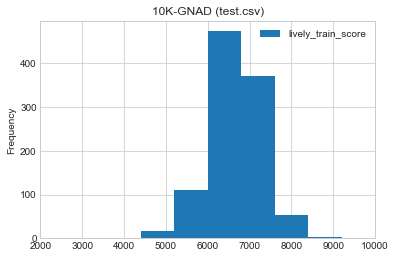

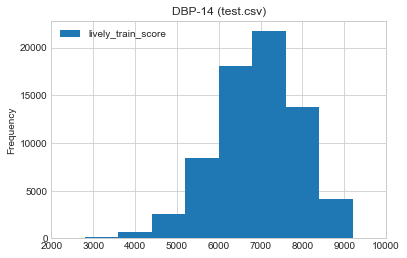

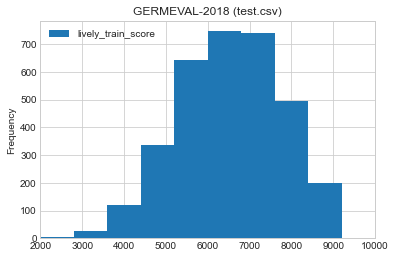

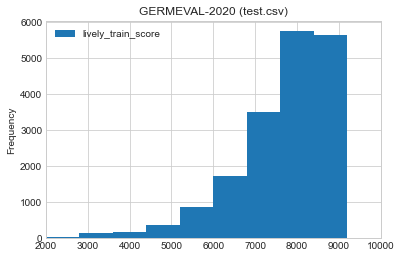

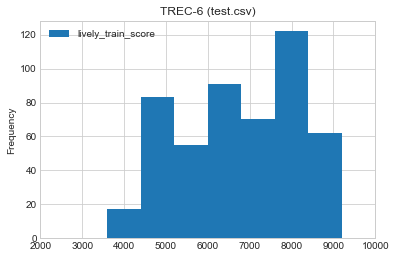

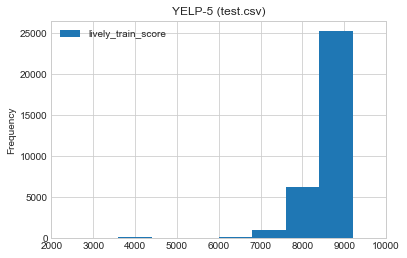

In [56]:
plot_score(score='lively_train_score', train_test='test', xlim=(2000,10000))

In [6]:
describe_score(score='lively_train_score')

lively\lively_train_score_10K-GNAD_test.csv 6659.566412345459 +- 621.5000316253523
lively\lively_train_score_10K-GNAD_train.csv 6695.798039983468 +- 654.7000966371661
lively\lively_train_score_DBP-14_test.csv 6944.4816286267605 +- 1011.7001993160851
lively\lively_train_score_DBP-14_train.csv 6948.593787368336 +- 1011.5420725983089
lively\lively_train_score_GERMEVAL-2018_test.csv 6610.923317785447 +- 1301.6524397238481
lively\lively_train_score_GERMEVAL-2018_train.csv 7959.648213004955 +- 1070.9131715414171
lively\lively_train_score_GERMEVAL-2020_test.csv 7919.118057613514 +- 1256.5711327350296
lively\lively_train_score_GERMEVAL-2020_train.csv 7939.94254590391 +- 1241.821626240463
lively\lively_train_score_TREC-6_test.csv 6806.908549064987 +- 1324.6552264422673
lively\lively_train_score_TREC-6_train.csv 7759.936718935462 +- 577.982398103182
lively\lively_train_score_YELP-5_test.csv 8901.749077132892 +- 701.602188305371
lively\lively_train_score_YELP-5_train.csv 8897.843219818204 +- 716.

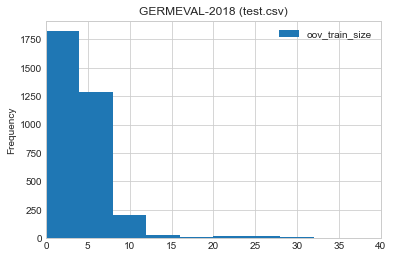

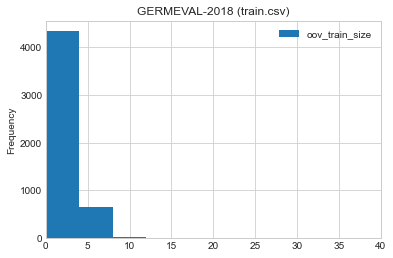

In [57]:
plot_score(score='oov_train_size', dataset='GERMEVAL-2018', xlim=(0,40))

In [29]:
describe_score(score='oov_train_size')

lively\oov_train_size_10K-GNAD_test.csv 63.99805447470817 +- 55.33022046845272
lively\oov_train_size_10K-GNAD_train.csv 61.852244456462955 +- 46.74353247692574
lively\oov_train_size_DBP-14_test.csv 7.4224 +- 5.163458334574351
lively\oov_train_size_DBP-14_train.csv 7.3853446428571425 +- 5.08836842622767
lively\oov_train_size_GERMEVAL-2018_test.csv 4.207180694526192 +- 6.862374424851154
lively\oov_train_size_GERMEVAL-2018_train.csv 1.7314833300059893 +- 1.627062777682404
lively\oov_train_size_GERMEVAL-2020_test.csv 1.7886602870813397 +- 1.4742070413245418
lively\oov_train_size_GERMEVAL-2020_train.csv 1.7378623936071584 +- 1.425632595376492
lively\oov_train_size_TREC-6_test.csv 0.634 +- 0.6818899822521164
lively\oov_train_size_TREC-6_train.csv 0.0 +- 0.0
lively\oov_train_size_YELP-5_test.csv 5.4793 +- 8.195147022396508
lively\oov_train_size_YELP-5_train.csv 5.4861784615384614 +- 8.272819839863605


In [70]:
describe_score()

lively\lively_default_score_10K-GNAD_test.csv 4657.308743331424 +- 467.52500650464737
lively\lively_default_score_10K-GNAD_train.csv 4651.072925557061 +- 481.40894310774127
lively\lively_default_score_DBP-14_test.csv 2880.8232818646643 +- 749.7060555930624
lively\lively_default_score_DBP-14_train.csv 2881.1521005313057 +- 749.4112764067098
lively\lively_default_score_GERMEVAL-2018_test.csv 3948.3246957255406 +- 1289.29047649114
lively\lively_default_score_GERMEVAL-2018_train.csv 4038.1193967301388 +- 1214.9569081826085
lively\lively_default_score_GERMEVAL-2020_test.csv 5269.733669570502 +- 1172.0365104590712
lively\lively_default_score_GERMEVAL-2020_train.csv 5260.528297321936 +- 1186.1207877541044
lively\lively_default_score_TREC-6_test.csv 3636.7253563718273 +- 1038.83870557553
lively\lively_default_score_TREC-6_train.csv 3762.578757228327 +- 1048.2440326098333
lively\lively_default_score_YELP-5_test.csv 4151.979873545459 +- 728.7871543095866
lively\lively_default_score_YELP-5_train.

In [33]:
ds_list = ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020', 'YELP-5', 'DBP-14', 'TREC-6']
for ds in ds_list:
    print('-'*60)
    print(ds)
    print(sample_top_n_texts(score='vocab_size', dataset=ds, train_test='train', ascending=True, n=5))

------------------------------------------------------------
10K-GNAD
[(array([4], dtype=int64), 'Nationale IMEI-Sperre angestrebt. '), (array([4], dtype=int64), 'PORTUGAL: UNGARN: ISLAND:'), (array([5], dtype=int64), 'Vorläufiges Endergebnis mit Mandatsverteilung. '), (array([9], dtype=int64), 'Gemeindeergebnisse, Mandate und mögliche Koalitionen im Überblick. '), (array([10], dtype=int64), 'Das Land im Herzen Afrikas kommt nicht zur Ruhe. ')]
------------------------------------------------------------
GERMEVAL-2018
[(array([5], dtype=int64), 'Brettl Spitzen gucken auf BR'), (array([5], dtype=int64), 'Toony ist ein polnischer Hurensohn'), (array([5], dtype=int64), 'Deutschland Erwache aus deinem Schlaf'), (array([5], dtype=int64), 'Bin gerade so Mett ........'), (array([5], dtype=int64), 'Doitsche kauft nicht bai Türken')]
------------------------------------------------------------
GERMEVAL-2020
[(array([2], dtype=int64), 'tröstzet.gut.einfach.schlecht.'), (array([2], dtype=int64), 

In [34]:
ds_list = ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020', 'YELP-5', 'DBP-14', 'TREC-6']
for ds in ds_list:
    print('-'*60)
    print(ds)
    print(sample_top_n_texts(score='vocab_size', dataset=ds, train_test='train', n=5))

------------------------------------------------------------
10K-GNAD
[(array([1320], dtype=int64), 'Neues Windows wird seit Mittwoch als Download an private Nutzer verteilt. Da ist es nun also. Das erste Windows unter der Ägide des neuen Microsoft-Chefs Satya Nadella. Und sein Baby namens Windows 10 soll nicht nur jene Nutzer zurückgewinnen, die mit dem zu radikal auf Touch first ausgerichteten Windows 8 nichts anfangen konnten, sondern auch die Ära von Windows 10 als Dienstleistung einleiten. Seit heute verteilt Microsoft sein neues Betriebssystem Windows 10 an private Anwender – als Download. Das Upgrade gibt es kostenlos für alle, die derzeit mit Windows 7 oder 8 arbeiten. Später soll es dann parallel auf allen Geräten laufen, auch auf dem Smartphone und der Xbox. Einen Nachfolger soll es nicht mehr geben – nur noch fortlaufende Funktions- und Sicherheitsupdates. Nach einem Flop mit dem Vorgängersystem Windows 8 übersprang Microsoft die Nachfolgenummer 9, um mit einer runden Zahl n

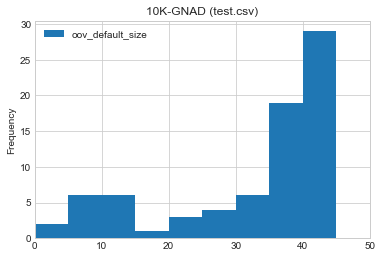

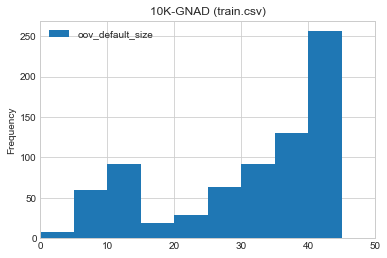

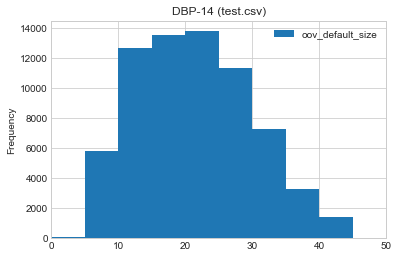

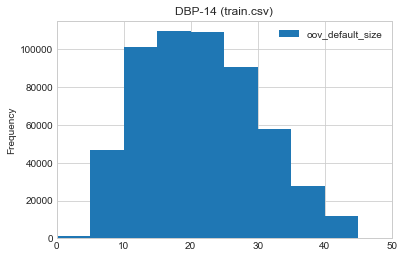

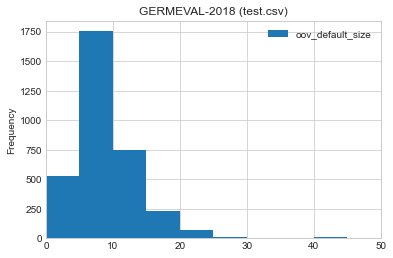

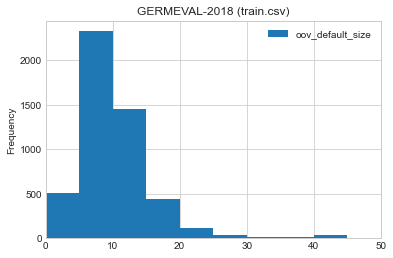

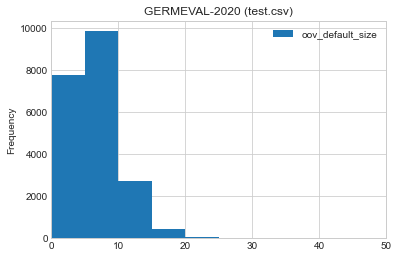

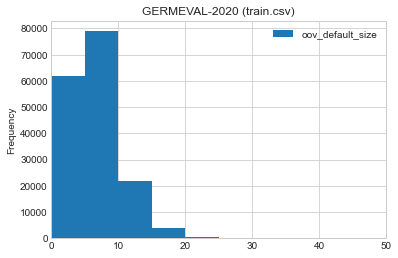

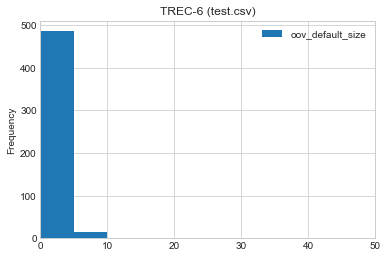

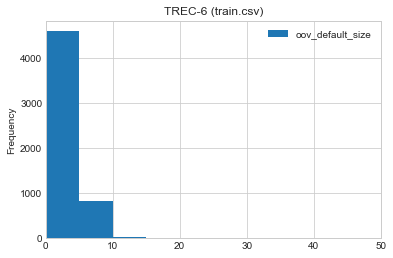

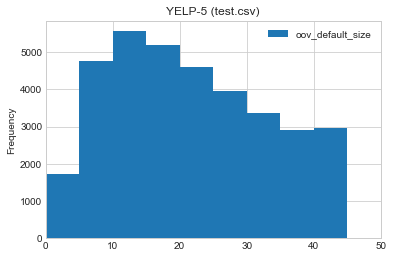

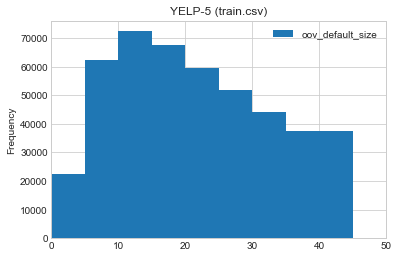

In [64]:
plot_score(score='oov_default_size', xlim=(0,50))

In [65]:
ds_list = ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020', 'YELP-5', 'DBP-14', 'TREC-6']
ds_list = ['GERMEVAL-2020']
for ds in ds_list:
    print('-'*60)
    print(ds)
    print(sample_top_n_texts(score='oov_default_size', dataset=ds, train_test='train', n=50))

------------------------------------------------------------
GERMEVAL-2020
[(array([59], dtype=int64), 'the water implies that they are in relation. The color shows that two are more in relation than another. Two people are in conection (talking/listening). The non-blue person may be excluded. This person may be wanting attention..The water lines symbolize that they may be in relation. The blue color may symb. that two are more so than the non-blue. The non-blue person may vye for attention. The others may or may not.'), (array([53], dtype=int64), "Make the other one clear, that enough is enough. Make his/her point of view clear.At the same tame a bit tensed but also very sure of him/herself since he/she knows he/she's right.Because it almost doesn't bother her/him anymore what the other says, no need to.the sitting person is almost impressed, that the standing person is so sure of himself, that he thinks the whole thing over."), (array([53], dtype=int64), 'He wants the other person to